In [2]:
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 5.3 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import re
import requests
from bs4 import BeautifulSoup
import csv
import re
import time
from typing import Dict, List, Optional
import requests
from bs4 import BeautifulSoup
from requests.adapters import HTTPAdapter, Retry
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
from typing import List, Dict
from transformers import pipeline
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Scrape Reviews from Trustpilot

In [6]:
def get_reviews_from_page(url: str, company_name: str) -> List[Dict[str, str]]:
    """
    Scrape reviews from a single Trustpilot page.

    Args:
        url: The URL of the Trustpilot page to scrape
        company_name: Name of the company being scraped

    Returns:
        List of dictionaries containing review text, rating, and company name
    """
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }

    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')

        reviews_data = []

        # Find all review cards
        review_cards = soup.find_all('article', {'class': lambda x: x and 'review' in x.lower()})

        # If the above doesn't work, try alternative selectors
        if not review_cards:
            review_cards = soup.find_all('div', {'data-service-review-card-paper': True})

        if not review_cards:
            review_cards = soup.find_all('section', {'class': lambda x: x and 'review' in x.lower()})

        for card in review_cards:
            try:
                # Extract rating (look for star rating)
                rating_elem = card.find('div', {'class': lambda x: x and 'star-rating' in x.lower()}) or \
                              card.find('img', {'alt': lambda x: x and 'star' in x.lower() if x else False}) or \
                              card.find('div', {'data-service-review-rating': True})

                rating = None
                if rating_elem:
                    # Try to get rating from data attribute
                    if rating_elem.get('data-service-review-rating'):
                        rating = rating_elem.get('data-service-review-rating')
                    # Try to get from img alt text
                    elif rating_elem.name == 'img' and rating_elem.get('alt'):
                        alt_text = rating_elem.get('alt')
                        # Extract number from text like "Rated 5 out of 5 stars"
                        rating = ''.join(filter(str.isdigit, alt_text.split()[1] if len(alt_text.split()) > 1 else alt_text))
                    # Try to count filled stars
                    else:
                        filled_stars = rating_elem.find_all('img', {'alt': lambda x: 'star' in x.lower() if x else False})
                        if filled_stars:
                            rating = str(len(filled_stars))

                # Extract review text
                review_text = None

                # Try multiple selectors for review text
                text_elem = card.find('p', {'class': lambda x: x and 'review-content' in x.lower()}) or \
                            card.find('div', {'class': lambda x: x and 'review-content' in x.lower()}) or \
                            card.find('p', {'data-service-review-text-typography': True}) or \
                            card.find('div', {'data-service-review-text': True})

                if text_elem:
                    review_text = text_elem.get_text(strip=True)

                # Only add if we have both rating and text
                if rating and review_text:
                    reviews_data.append({
                        'company': company_name,
                        'rating': rating,
                        'review': review_text
                    })

            except Exception as e:
                print(f"Error parsing review card: {e}")
                continue

        return reviews_data

    except requests.exceptions.RequestException as e:
        print(f"Error fetching page {url}: {e}")
        return []

def scrape_trustpilot_reviews(company_domain: str, num_pages: int = 10) -> pd.DataFrame:
    """
    Scrape multiple pages of Trustpilot reviews for a single company.

    Args:
        company_domain: Domain of the company (e.g., 'www.mcdonalds.com')
        num_pages: Number of pages to scrape (default: 10)

    Returns:
        Pandas DataFrame with reviews, ratings, and company name
    """
    base_url = f"https://www.trustpilot.com/review/{company_domain}"
    all_reviews = []

    for page_num in range(1, num_pages + 1):
        print(f"  Scraping page {page_num}/{num_pages}...")

        # Construct URL for each page
        if page_num == 1:
            url = base_url
        else:
            url = f"{base_url}?page={page_num}"

        # Get reviews from the page
        page_reviews = get_reviews_from_page(url, company_domain)
        all_reviews.extend(page_reviews)

        print(f"  Found {len(page_reviews)} reviews on page {page_num}")

        # Be polite - add a delay between requests
        if page_num < num_pages:
            time.sleep(2)

    # Create DataFrame
    df = pd.DataFrame(all_reviews)

    print(f"  Total reviews for {company_domain}: {len(df)}\n")

    return df

def scrape_multiple_companies(company_list: List[str], num_pages: int = 10) -> pd.DataFrame:
    """
    Scrape Trustpilot reviews for multiple companies.

    Args:
        company_list: List of company domains to scrape
        num_pages: Number of pages to scrape per company (default: 10)

    Returns:
        Combined Pandas DataFrame with all reviews
    """
    all_companies_data = []

    for idx, company in enumerate(company_list, 1):
        print(f"\n[{idx}/{len(company_list)}] Scraping reviews for: {company}")
        print("-" * 60)

        try:
            df = scrape_trustpilot_reviews(company, num_pages)
            if not df.empty:
                all_companies_data.append(df)
            else:
                print(f"  No reviews found for {company}")
        except Exception as e:
            print(f"  Error scraping {company}: {e}")

        # Add delay between companies
        if idx < len(company_list):
            print("  Waiting before next company...")
            time.sleep(3)

    # Combine all dataframes
    if all_companies_data:
        combined_df = pd.concat(all_companies_data, ignore_index=True)
        print("\n" + "=" * 60)
        print(f"TOTAL REVIEWS COLLECTED: {len(combined_df)}")
        print("=" * 60)
        return combined_df
    else:
        print("\nNo reviews collected from any company.")
        return pd.DataFrame()

In [7]:
# Main execution
if __name__ == "__main__":
    # List of companies to scrape
    company_list = [
        'www.mcdonalds.com',
        'burger-king.de',
        'www.wendys.com',
        'locations.in-n-out.com',
        'www.chick-fil-a.com',
        'carlsjr.com',
        'jackinthebox.com',
        'dairyqueen.com',
        'whataburger.com',
        'www.hardees.com',
        'sonicdrivein.com'
    ]

    # Scrape 10 pages per company
    print("Starting Trustpilot scraper for multiple fast food chains...")
    print("=" * 60)

    df = scrape_multiple_companies(company_list, num_pages=10)

    if not df.empty:
        # Display first few rows
        print("\nFirst 10 reviews:")
        print(df.head(10))

        # Save to CSV
        df.to_csv('fast_food_trustpilot_reviews.csv', index=False, encoding='utf-8')
        print("\n✓ Reviews saved to 'fast_food_trustpilot_reviews.csv'")

        # Display statistics by company
        print("\n" + "=" * 60)
        print("REVIEWS PER COMPANY:")
        print("=" * 60)
        print(df['company'].value_counts())

        print("\n" + "=" * 60)
        print("RATING DISTRIBUTION:")
        print("=" * 60)
        print(df['rating'].value_counts().sort_index())
    else:
        print("\nNo data to save.")

Starting Trustpilot scraper for multiple fast food chains...

[1/11] Scraping reviews for: www.mcdonalds.com
------------------------------------------------------------
  Scraping page 1/10...
  Found 19 reviews on page 1
  Scraping page 2/10...
  Found 20 reviews on page 2
  Scraping page 3/10...
  Found 19 reviews on page 3
  Scraping page 4/10...
  Found 19 reviews on page 4
  Scraping page 5/10...
  Found 20 reviews on page 5
  Scraping page 6/10...
  Found 20 reviews on page 6
  Scraping page 7/10...
  Found 20 reviews on page 7
  Scraping page 8/10...
  Found 20 reviews on page 8
  Scraping page 9/10...
  Found 17 reviews on page 9
  Scraping page 10/10...
  Found 18 reviews on page 10
  Total reviews for www.mcdonalds.com: 192

  Waiting before next company...

[2/11] Scraping reviews for: burger-king.de
------------------------------------------------------------
  Scraping page 1/10...
  Found 20 reviews on page 1
  Scraping page 2/10...
  Found 18 reviews on page 2
  Scrapin

In [13]:
df_reviews = pd.read_csv('fast_food_trustpilot_reviews.csv')

In [14]:
df_reviews

,company,rating,review
0,www.mcdonalds.com,3,SF MCD isn't that good! I mean the food qualit...
1,www.mcdonalds.com,1,Always items missing from our delivery orders....
2,www.mcdonalds.com,5,Food is the same everywhere which is kinda the...
3,www.mcdonalds.com,5,"The serving of chicken meal is now larger, com..."
4,www.mcdonalds.com,5,"Place was clean, which isn’t always the case w..."
...,...,...,...
1612,sonicdrivein.com,1,"I went To drive-in #6917, which is the newer o..."
1613,sonicdrivein.com,1,Got charged 2 different amounts on the same da...
1614,sonicdrivein.com,1,Just wanted to say how stupid their new commer...
1615,sonicdrivein.com,1,I find it sad that sonic is helping to push th...


In [15]:
df_reviews.groupby('company').agg(avg_rating=('rating','mean')).round(2).sort_values(by='avg_rating')

,avg_rating
company,
sonicdrivein.com,1.37
www.mcdonalds.com,1.86
jackinthebox.com,1.96
whataburger.com,2.19
dairyqueen.com,2.20
www.hardees.com,2.32
www.chick-fil-a.com,2.36
burger-king.de,2.41
carlsjr.com,2.42


# Perform Sentiment Analysis
sentiment analysis using the Transformers library with DistilBERT, which is both fast and accurate

In [16]:
def setup_sentiment_analyzer():
    """
    Initialize the sentiment analysis pipeline using a powerful pre-trained model.
    Uses distilbert-base-uncased-finetuned-sst-2-english for speed and accuracy.

    Returns:
        Sentiment analysis pipeline
    """
    print("Loading sentiment analysis model...")

    # Check if CUDA is available for GPU acceleration
    device = 0 if torch.cuda.is_available() else -1

    if device == 0:
        print("✓ GPU detected - using CUDA for faster processing")
    else:
        print("✓ Using CPU for processing")

    # Load the sentiment analysis pipeline
    # This model is fast and accurate for sentiment analysis
    sentiment_analyzer = pipeline(
        "sentiment-analysis",
        model="distilbert-base-uncased-finetuned-sst-2-english",
        device=device,
        truncation=True,
        max_length=512
    )

    print("✓ Model loaded successfully\n")
    return sentiment_analyzer

def analyze_sentiment_batch(reviews, sentiment_analyzer, batch_size=32):
    """
    Perform sentiment analysis on reviews in batches for better performance.

    Args:
        reviews: List of review texts
        sentiment_analyzer: Pre-loaded sentiment analysis pipeline
        batch_size: Number of reviews to process at once

    Returns:
        List of dictionaries with sentiment labels and scores
    """
    results = []

    # Process in batches with progress bar
    for i in tqdm(range(0, len(reviews), batch_size), desc="Analyzing sentiment"):
        batch = reviews[i:i + batch_size]

        # Handle any None or empty values
        batch = [str(review) if review and str(review).strip() else "No review text" for review in batch]

        try:
            batch_results = sentiment_analyzer(batch)
            results.extend(batch_results)
        except Exception as e:
            print(f"\nError processing batch {i//batch_size + 1}: {e}")
            # Add placeholder results for failed batch
            results.extend([{'label': 'UNKNOWN', 'score': 0.0}] * len(batch))

    return results

def add_sentiment_to_dataframe(df, sentiment_results):
    """
    Add sentiment analysis results to the dataframe.

    Args:
        df: Original dataframe with reviews
        sentiment_results: List of sentiment analysis results

    Returns:
        DataFrame with added sentiment columns
    """
    # Extract labels and scores
    df['sentiment'] = [result['label'] for result in sentiment_results]
    df['sentiment_score'] = [result['score'] for result in sentiment_results]

    # Convert POSITIVE/NEGATIVE to more readable format
    df['sentiment'] = df['sentiment'].map({
        'POSITIVE': 'Positive',
        'NEGATIVE': 'Negative',
        'UNKNOWN': 'Unknown'
    })

    # Add confidence level category
    df['confidence'] = df['sentiment_score'].apply(lambda x:
                                                   'High' if x > 0.9 else 'Medium' if x > 0.7 else 'Low'
                                                   )

    return df

def analyze_reviews_sentiment(input_csv='fast_food_trustpilot_reviews.csv',
                              output_csv='fast_food_reviews_with_sentiment.csv',
                              batch_size=32):
    """
    Main function to perform sentiment analysis on scraped reviews.

    Args:
        input_csv: Path to input CSV file with reviews
        output_csv: Path to save output CSV with sentiment analysis
        batch_size: Number of reviews to process in each batch
    """
    print("=" * 70)
    print("SENTIMENT ANALYSIS FOR TRUSTPILOT REVIEWS")
    print("=" * 70)

    # Load the data
    print(f"\nLoading reviews from '{input_csv}'...")
    try:
        df = pd.read_csv(input_csv)
        print(f"✓ Loaded {len(df)} reviews from {df['company'].nunique()} companies\n")
    except FileNotFoundError:
        print(f"Error: File '{input_csv}' not found.")
        print("Please run the scraper script first to generate the reviews file.")
        return

    # Setup sentiment analyzer
    sentiment_analyzer = setup_sentiment_analyzer()

    # Perform sentiment analysis
    print(f"Analyzing sentiment for {len(df)} reviews...")
    print(f"Processing in batches of {batch_size}...\n")

    sentiment_results = analyze_sentiment_batch(
        df['review'].tolist(),
        sentiment_analyzer,
        batch_size=batch_size
    )

    # Add results to dataframe
    print("\nAdding sentiment data to dataframe...")
    df = add_sentiment_to_dataframe(df, sentiment_results)

    # Save results
    print(f"✓ Saving results to '{output_csv}'...")
    df.to_csv(output_csv, index=False, encoding='utf-8')
    print(f"✓ Results saved successfully!\n")

    # Display statistics
    print("=" * 70)
    print("SENTIMENT ANALYSIS SUMMARY")
    print("=" * 70)

    print("\n1. Overall Sentiment Distribution:")
    print("-" * 70)
    sentiment_dist = df['sentiment'].value_counts()
    for sentiment, count in sentiment_dist.items():
        percentage = (count / len(df)) * 100
        print(f"   {sentiment}: {count} ({percentage:.1f}%)")

    print("\n2. Sentiment by Company:")
    print("-" * 70)
    sentiment_by_company = df.groupby(['company', 'sentiment']).size().unstack(fill_value=0)
    sentiment_by_company['Total'] = sentiment_by_company.sum(axis=1)
    sentiment_by_company['Positive %'] = (sentiment_by_company.get('Positive', 0) /
                                          sentiment_by_company['Total'] * 100).round(1)
    print(sentiment_by_company.sort_values('Positive %', ascending=False))

    print("\n3. Confidence Level Distribution:")
    print("-" * 70)
    confidence_dist = df['confidence'].value_counts()
    for conf, count in confidence_dist.items():
        percentage = (count / len(df)) * 100
        print(f"   {conf} Confidence: {count} ({percentage:.1f}%)")

    print("\n4. Average Sentiment Score by Rating:")
    print("-" * 70)
    avg_by_rating = df.groupby('rating').agg({
        'sentiment_score': 'mean',
        'review': 'count'
    }).round(3)
    avg_by_rating.columns = ['Avg Sentiment Score', 'Count']
    print(avg_by_rating)

    print("\n5. Sample Reviews:")
    print("-" * 70)
    print("\nMost Positive Review:")
    most_positive = df[df['sentiment'] == 'Positive'].nlargest(1, 'sentiment_score')
    if not most_positive.empty:
        row = most_positive.iloc[0]
        print(f"   Company: {row['company']}")
        print(f"   Rating: {row['rating']}")
        print(f"   Score: {row['sentiment_score']:.3f}")
        print(f"   Review: {row['review'][:200]}...")

    print("\nMost Negative Review:")
    most_negative = df[df['sentiment'] == 'Negative'].nlargest(1, 'sentiment_score')
    if not most_negative.empty:
        row = most_negative.iloc[0]
        print(f"   Company: {row['company']}")
        print(f"   Rating: {row['rating']}")
        print(f"   Score: {row['sentiment_score']:.3f}")
        print(f"   Review: {row['review'][:200]}...")

    print("\n" + "=" * 70)
    print("Analysis complete!")
    print("=" * 70)

In [17]:
if __name__ == "__main__":
    # Run sentiment analysis
    # Adjust batch_size based on your system:
    # - GPU with 8GB+ VRAM: batch_size=64 or 128
    # - GPU with 4GB VRAM: batch_size=32
    # - CPU only: batch_size=16 or 8

    analyze_reviews_sentiment(
        input_csv='fast_food_trustpilot_reviews.csv',
        output_csv='fast_food_reviews_with_sentiment.csv',
        batch_size=32
    )

SENTIMENT ANALYSIS FOR TRUSTPILOT REVIEWS

Loading reviews from 'fast_food_trustpilot_reviews.csv'...
✓ Loaded 1617 reviews from 11 companies

Loading sentiment analysis model...
✓ Using CPU for processing


Device set to use cpu


✓ Model loaded successfully

Analyzing sentiment for 1617 reviews...
Processing in batches of 32...



Analyzing sentiment: 100%|██████████| 51/51 [06:05<00:00,  7.16s/it]


Adding sentiment data to dataframe...
✓ Saving results to 'fast_food_reviews_with_sentiment.csv'...
✓ Results saved successfully!

SENTIMENT ANALYSIS SUMMARY

1. Overall Sentiment Distribution:
----------------------------------------------------------------------
   Negative: 1160 (71.7%)
   Positive: 457 (28.3%)

2. Sentiment by Company:
----------------------------------------------------------------------
sentiment               Negative  Positive  Total  Positive %
company                                                      
locations.in-n-out.com         9        38     47        80.9
www.wendys.com               109        82    191        42.9
burger-king.de                85        43    128        33.6
carlsjr.com                   96        43    139        30.9
www.chick-fil-a.com          136        58    194        29.9
www.hardees.com              139        58    197        29.4
dairyqueen.com                81        32    113        28.3
whataburger.com             

In [18]:
df_reviews_sent = pd.read_csv('fast_food_reviews_with_sentiment.csv')

In [19]:
df_reviews_sent

,company,rating,review,sentiment,sentiment_score,confidence
0,www.mcdonalds.com,3,SF MCD isn't that good! I mean the food qualit...,Negative,0.992633,High
1,www.mcdonalds.com,1,Always items missing from our delivery orders....,Negative,0.998818,High
2,www.mcdonalds.com,5,Food is the same everywhere which is kinda the...,Positive,0.946746,High
3,www.mcdonalds.com,5,"The serving of chicken meal is now larger, com...",Positive,0.999021,High
4,www.mcdonalds.com,5,"Place was clean, which isn’t always the case w...",Positive,0.999596,High
...,...,...,...,...,...,...
1612,sonicdrivein.com,1,"I went To drive-in #6917, which is the newer o...",Negative,0.999624,High
1613,sonicdrivein.com,1,Got charged 2 different amounts on the same da...,Negative,0.998951,High
1614,sonicdrivein.com,1,Just wanted to say how stupid their new commer...,Negative,0.999769,High
1615,sonicdrivein.com,1,I find it sad that sonic is helping to push th...,Negative,0.998352,High


In [20]:
# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

def load_data(filepath='fast_food_reviews_with_sentiment.csv'):
    """Load the sentiment analysis results."""
    print(f"Loading data from {filepath}...")
    df = pd.read_csv(filepath)
    print(f"✓ Loaded {len(df)} reviews from {df['company'].nunique()} companies\n")
    return df

def plot_overall_sentiment_distribution(df, ax):
    """Plot overall sentiment distribution with percentages."""
    sentiment_counts = df['sentiment'].value_counts()
    colors = ['#2ecc71' if s == 'Positive' else '#e74c3c' for s in sentiment_counts.index]

    bars = ax.bar(sentiment_counts.index, sentiment_counts.values, color=colors, alpha=0.7, edgecolor='black')

    # Add percentage labels on bars
    total = len(df)
    for bar in bars:
        height = bar.get_height()
        percentage = (height / total) * 100
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}\n({percentage:.1f}%)',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

    ax.set_title('Overall Sentiment Distribution', fontsize=14, fontweight='bold', pad=20)
    ax.set_ylabel('Number of Reviews', fontsize=12)
    ax.set_xlabel('Sentiment', fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

def plot_sentiment_by_company(df, ax):
    """Plot sentiment distribution by company with stacked bars."""
    sentiment_by_company = df.groupby(['company', 'sentiment']).size().unstack(fill_value=0)

    # Calculate percentages
    sentiment_pct = sentiment_by_company.div(sentiment_by_company.sum(axis=1), axis=0) * 100

    # Sort by positive percentage
    sentiment_pct = sentiment_pct.sort_values('Positive', ascending=True)

    # Create horizontal stacked bar chart
    sentiment_pct.plot(kind='barh', stacked=True, ax=ax,
                       color=['#e74c3c', '#2ecc71'],
                       edgecolor='black', linewidth=0.5)

    ax.set_title('Sentiment Distribution by Company (%)', fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Percentage', fontsize=12)
    ax.set_ylabel('Company', fontsize=12)
    ax.legend(title='Sentiment', loc='lower right')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add percentage labels
    for i, company in enumerate(sentiment_pct.index):
        pos_pct = sentiment_pct.loc[company, 'Positive']
        ax.text(pos_pct/2, i, f'{pos_pct:.1f}%',
                ha='center', va='center', fontweight='bold', color='white')

def plot_rating_vs_sentiment(df, ax):
    """Plot the relationship between star rating and sentiment."""
    # Calculate sentiment distribution for each rating
    rating_sentiment = df.groupby(['rating', 'sentiment']).size().unstack(fill_value=0)
    rating_sentiment_pct = rating_sentiment.div(rating_sentiment.sum(axis=1), axis=0) * 100

    # Plot
    x = np.arange(len(rating_sentiment_pct.index))
    width = 0.35

    bars1 = ax.bar(x - width/2, rating_sentiment_pct['Negative'], width,
                   label='Negative', color='#e74c3c', alpha=0.8, edgecolor='black')
    bars2 = ax.bar(x + width/2, rating_sentiment_pct['Positive'], width,
                   label='Positive', color='#2ecc71', alpha=0.8, edgecolor='black')

    ax.set_title('Sentiment vs Star Rating', fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Star Rating', fontsize=12)
    ax.set_ylabel('Percentage (%)', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(rating_sentiment_pct.index)
    ax.legend()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 5:  # Only show if significant
                ax.text(bar.get_x() + bar.get_width()/2., height/2,
                        f'{height:.0f}%', ha='center', va='center',
                        fontweight='bold', color='white', fontsize=9)

def plot_sentiment_score_distribution(df, ax):
    """Plot distribution of sentiment scores."""
    positive_scores = df[df['sentiment'] == 'Positive']['sentiment_score']
    negative_scores = df[df['sentiment'] == 'Negative']['sentiment_score']

    ax.hist(positive_scores, bins=30, alpha=0.6, label='Positive',
            color='#2ecc71', edgecolor='black')
    ax.hist(negative_scores, bins=30, alpha=0.6, label='Negative',
            color='#e74c3c', edgecolor='black')

    ax.set_title('Sentiment Score Distribution (Confidence)', fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Sentiment Score', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.legend()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

def plot_company_comparison(df, ax):
    """Compare companies by average sentiment score and review count."""
    company_stats = df.groupby('company').agg({
        'sentiment_score': 'mean',
        'review': 'count',
        'sentiment': lambda x: (x == 'Positive').sum() / len(x) * 100
    }).round(2)
    company_stats.columns = ['Avg Sentiment Score', 'Review Count', 'Positive %']
    company_stats = company_stats.sort_values('Positive %', ascending=False)

    # Create scatter plot
    scatter = ax.scatter(company_stats['Review Count'],
                         company_stats['Positive %'],
                         s=company_stats['Avg Sentiment Score'] * 500,
                         alpha=0.6, c=company_stats['Positive %'],
                         cmap='RdYlGn', edgecolors='black', linewidth=1.5)

    # Add company labels
    for idx, row in company_stats.iterrows():
        ax.annotate(idx.split('.')[0][:15],
                    (row['Review Count'], row['Positive %']),
                    fontsize=8, ha='center')

    ax.set_title('Company Performance: Reviews vs Positive Sentiment',
                 fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Number of Reviews', fontsize=12)
    ax.set_ylabel('Positive Sentiment %', fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Positive %', rotation=270, labelpad=20)

def plot_confidence_levels(df, ax):
    """Plot confidence level distribution."""
    confidence_counts = df['confidence'].value_counts()
    colors_conf = {'High': '#2ecc71', 'Medium': '#f39c12', 'Low': '#e74c3c'}
    colors = [colors_conf[conf] for conf in confidence_counts.index]

    wedges, texts, autotexts = ax.pie(confidence_counts.values,
                                      labels=confidence_counts.index,
                                      autopct='%1.1f%%',
                                      colors=colors,
                                      startangle=90,
                                      explode=[0.05] * len(confidence_counts))

    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(11)

    for text in texts:
        text.set_fontsize(12)
        text.set_fontweight('bold')

    ax.set_title('Model Confidence Levels', fontsize=14, fontweight='bold', pad=20)

def create_wordcloud(df, sentiment_type, ax):
    """Create word cloud for positive or negative reviews."""
    reviews = df[df['sentiment'] == sentiment_type]['review'].dropna()
    text = ' '.join(reviews.astype(str))

    color = '#2ecc71' if sentiment_type == 'Positive' else '#e74c3c'

    wordcloud = WordCloud(width=800, height=400,
                          background_color='white',
                          colormap='Greens' if sentiment_type == 'Positive' else 'Reds',
                          max_words=100,
                          contour_color='black',
                          contour_width=1).generate(text)

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'{sentiment_type} Reviews - Common Words',
                 fontsize=14, fontweight='bold', pad=20)
    ax.axis('off')

def create_comprehensive_dashboard(df):
    """Create a comprehensive visualization dashboard."""
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 14))
    gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)

    # Row 1: Overall metrics
    ax1 = fig.add_subplot(gs[0, 0])
    plot_overall_sentiment_distribution(df, ax1)

    ax2 = fig.add_subplot(gs[0, 1])
    plot_sentiment_score_distribution(df, ax2)

    ax3 = fig.add_subplot(gs[0, 2])
    plot_confidence_levels(df, ax3)

    # Row 2: Company comparisons
    ax4 = fig.add_subplot(gs[1, :2])
    plot_sentiment_by_company(df, ax4)

    ax5 = fig.add_subplot(gs[1, 2])
    plot_rating_vs_sentiment(df, ax5)

    # Row 3: Advanced analysis
    ax6 = fig.add_subplot(gs[2, :])
    plot_company_comparison(df, ax6)

    # Row 4: Word clouds
    ax7 = fig.add_subplot(gs[3, :2])
    create_wordcloud(df, 'Positive', ax7)

    ax8 = fig.add_subplot(gs[3, 2])
    create_wordcloud(df, 'Negative', ax8)

    fig.suptitle('Fast Food Reviews - Sentiment Analysis Dashboard',
                 fontsize=18, fontweight='bold', y=0.995)

    plt.savefig('sentiment_dashboard.png', dpi=300, bbox_inches='tight')
    print("✓ Dashboard saved as 'sentiment_dashboard.png'")

    plt.show()

def print_insights(df):
    """Print key insights from the analysis."""
    print("\n" + "="*70)
    print("KEY INSIGHTS")
    print("="*70)

    # Best and worst companies
    company_positive_pct = df.groupby('company')['sentiment'].apply(
        lambda x: (x == 'Positive').sum() / len(x) * 100
    ).sort_values(ascending=False)

    print(f"\n🏆 Best Performing Company:")
    print(f"   {company_positive_pct.index[0]}: {company_positive_pct.values[0]:.1f}% positive")

    print(f"\n⚠️  Worst Performing Company:")
    print(f"   {company_positive_pct.index[-1]}: {company_positive_pct.values[-1]:.1f}% positive")

    # Sentiment-rating correlation
    print(f"\n📊 Overall Statistics:")
    print(f"   Total Reviews: {len(df)}")
    print(f"   Positive: {(df['sentiment'] == 'Positive').sum()} ({(df['sentiment'] == 'Positive').sum()/len(df)*100:.1f}%)")
    print(f"   Negative: {(df['sentiment'] == 'Negative').sum()} ({(df['sentiment'] == 'Negative').sum()/len(df)*100:.1f}%)")
    print(f"   Avg Confidence: {df['sentiment_score'].mean():.3f}")

    print("\n" + "="*70)

def main():
    """Main function to run all visualizations."""
    print("="*70)
    print("SENTIMENT ANALYSIS VISUALIZATION")
    print("="*70)

    # Load data
    df = load_data('fast_food_reviews_with_sentiment.csv')

    # Create comprehensive dashboard
    print("Creating visualizations...")
    create_comprehensive_dashboard(df)

    # Print insights
    print_insights(df)

    print("\n✓ All visualizations complete!")

SENTIMENT ANALYSIS VISUALIZATION
Loading data from fast_food_reviews_with_sentiment.csv...
✓ Loaded 1617 reviews from 11 companies

Creating visualizations...
✓ Dashboard saved as 'sentiment_dashboard.png'


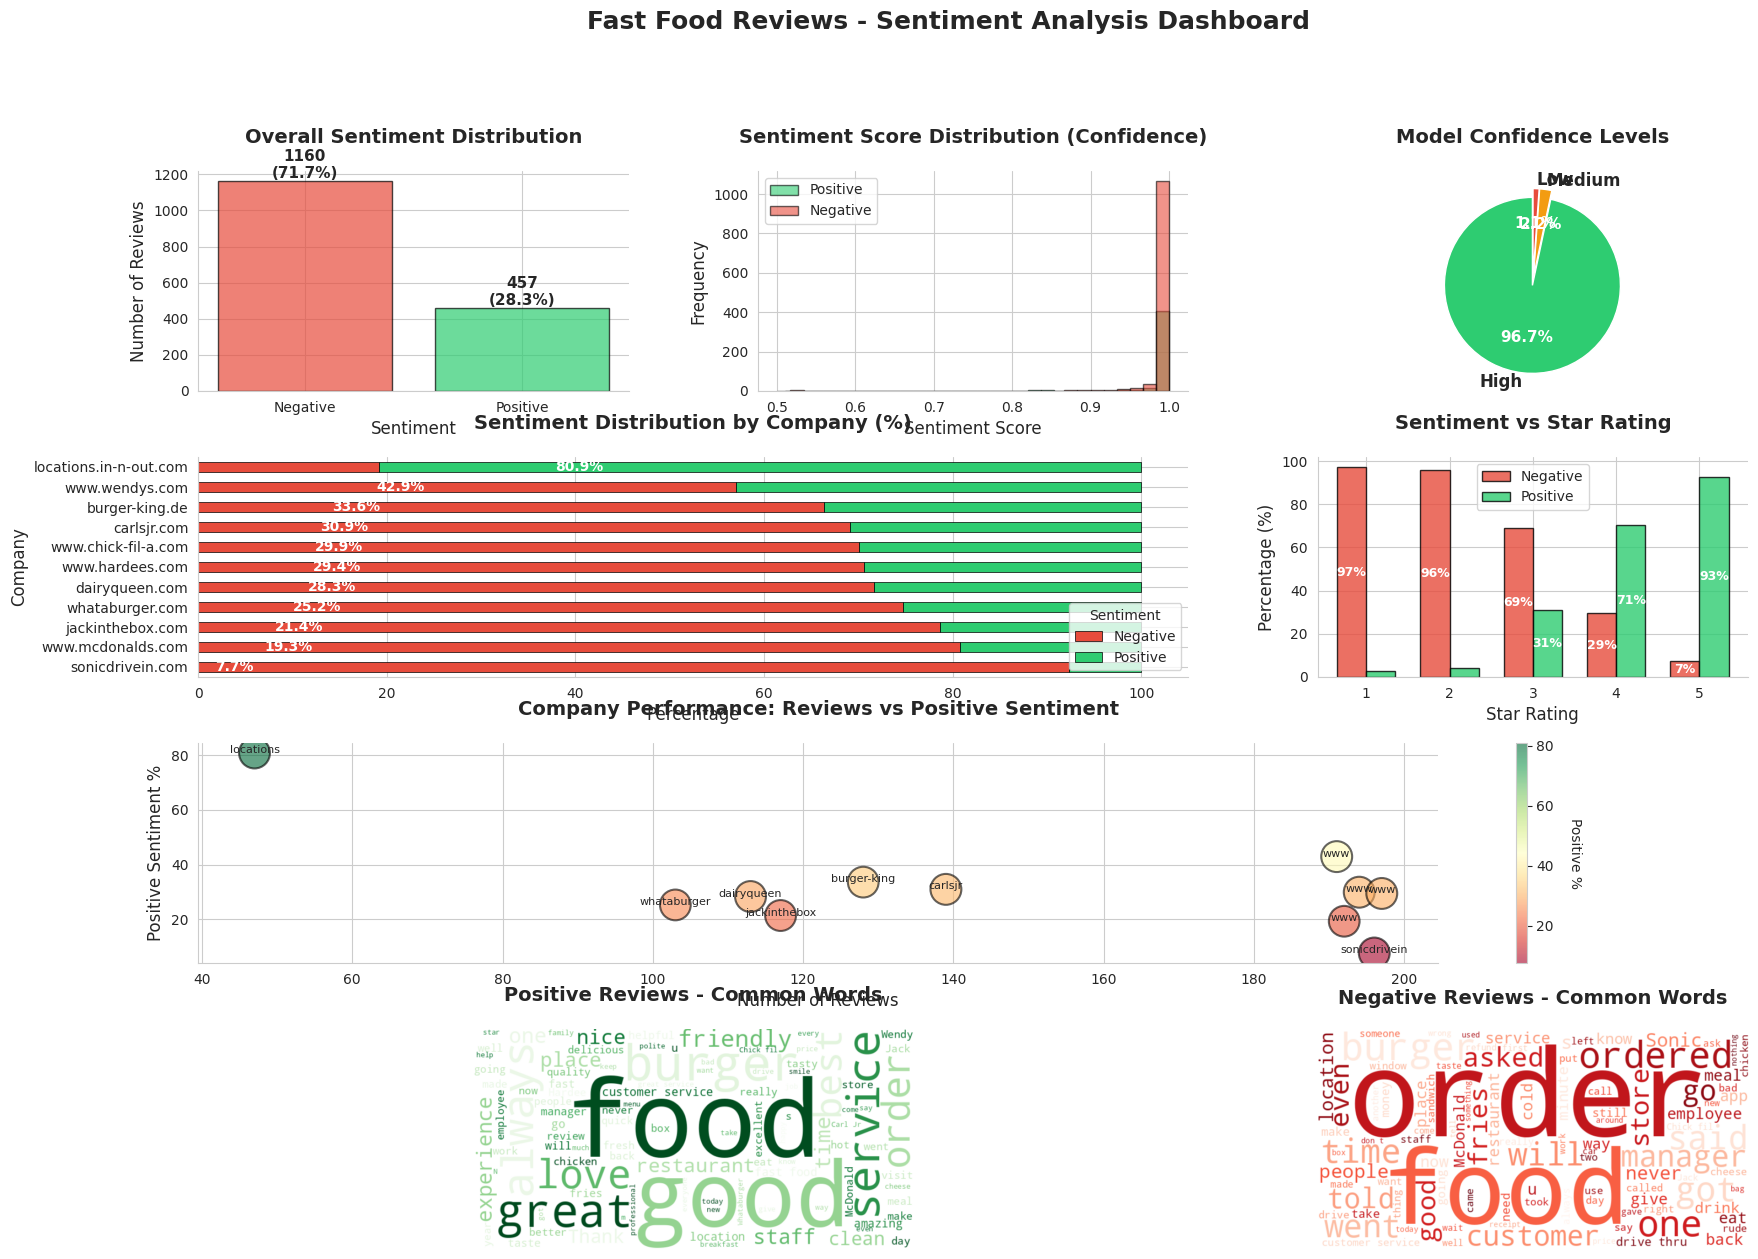


KEY INSIGHTS

🏆 Best Performing Company:
   locations.in-n-out.com: 80.9% positive

⚠️  Worst Performing Company:
   sonicdrivein.com: 7.7% positive

📊 Overall Statistics:
   Total Reviews: 1617
   Positive: 457 (28.3%)
   Negative: 1160 (71.7%)
   Avg Confidence: 0.988


✓ All visualizations complete!


In [21]:
if __name__ == "__main__":
    # Install required packages:
    # pip install pandas matplotlib seaborn wordcloud

    main()

# Topic Modeling

In [28]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

class CompanyTopicModeler:
    """
    State-of-the-art topic modeling using BERTopic with sentence transformers.
    BERTopic combines BERT embeddings, UMAP dimensionality reduction, and HDBSCAN clustering.
    """

    def __init__(self, min_topic_size=10, nr_topics='auto'):
        """
        Initialize the topic modeler.

        Args:
            min_topic_size: Minimum number of documents per topic
            nr_topics: Number of topics to extract ('auto' or integer)
        """
        print("Initializing BERTopic model...")

        # Use sentence transformer for embeddings (fast and accurate)
        self.embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

        # Configure UMAP for dimensionality reduction
        self.umap_model = UMAP(
            n_neighbors=15,
            n_components=5,
            min_dist=0.0,
            metric='cosine',
            random_state=42
        )

        # Configure HDBSCAN for clustering - using compatible parameters
        try:
            self.hdbscan_model = HDBSCAN(
                min_cluster_size=min_topic_size,
                metric='euclidean',
                cluster_selection_method='eom',
                prediction_data=True
            )
            self.use_hdbscan = True
        except Exception as e:
            print(f"  Warning: HDBSCAN initialization issue, using alternative clustering")
            # Use None to let BERTopic use default clustering
            self.hdbscan_model = None
            self.use_hdbscan = False

        # Configure vectorizer for topic representation
        self.vectorizer_model = CountVectorizer(
            stop_words='english',
            max_features=5000,
            ngram_range=(1, 2),
            min_df=2
        )

        # Initialize BERTopic with or without HDBSCAN
        if self.use_hdbscan:
            self.topic_model = BERTopic(
                embedding_model=self.embedding_model,
                umap_model=self.umap_model,
                hdbscan_model=self.hdbscan_model,
                vectorizer_model=self.vectorizer_model,
                top_n_words=10,
                nr_topics=nr_topics,
                calculate_probabilities=True,
                verbose=False
            )
        else:
            # Use BERTopic with default clustering (KMeans fallback)
            self.topic_model = BERTopic(
                embedding_model=self.embedding_model,
                umap_model=self.umap_model,
                vectorizer_model=self.vectorizer_model,
                top_n_words=10,
                nr_topics=nr_topics if nr_topics != 'auto' else 8,
                calculate_probabilities=False,  # Disable probabilities without HDBSCAN
                verbose=False
            )

        print("✓ BERTopic model initialized\n")

    def fit_transform(self, documents):
        """
        Fit the topic model and transform documents.

        Args:
            documents: List of document strings

        Returns:
            topics: Array of topic assignments
            probabilities: Array of topic probabilities
        """
        try:
            topics, probabilities = self.topic_model.fit_transform(documents)
            return topics, probabilities
        except Exception as e:
            print(f"  Error in fit_transform: {e}")
            return None, None

    def get_topic_info(self):
        """Get information about discovered topics."""
        try:
            return self.topic_model.get_topic_info()
        except Exception as e:
            print(f"  Error getting topic info: {e}")
            return pd.DataFrame()

    def get_topic_words(self, topic_id):
        """Get the top words for a specific topic."""
        try:
            topic_words = self.topic_model.get_topic(topic_id)
            return topic_words if topic_words else []
        except Exception as e:
            print(f"  Error getting words for topic {topic_id}: {e}")
            return []

    def get_representative_docs(self, topic_id, n_docs=3):
        """Get representative documents for a topic."""
        try:
            rep_docs = self.topic_model.get_representative_docs(topic_id)
            if rep_docs and len(rep_docs) > 0:
                return rep_docs[:min(n_docs, len(rep_docs))]
            return []
        except Exception as e:
            print(f"  Error getting representative docs for topic {topic_id}: {e}")
            return []

def prepare_documents(df, company):
    """
    Prepare documents for a specific company.

    Args:
        df: Full dataframe
        company: Company name to filter

    Returns:
        Filtered dataframe and list of documents
    """
    company_df = df[df['company'] == company].copy()

    # Clean and prepare documents
    documents = company_df['review'].fillna('').astype(str).tolist()
    documents = [doc.strip() for doc in documents if len(doc.strip()) > 10]

    # Update dataframe to match filtered documents
    company_df = company_df[company_df['review'].str.len() > 10].reset_index(drop=True)

    return company_df, documents

def analyze_company_topics(df, company, min_topic_size=10):
    """
    Perform topic modeling for a single company.

    Args:
        df: Full dataframe with reviews
        company: Company name
        min_topic_size: Minimum documents per topic

    Returns:
        Dictionary with analysis results
    """
    print(f"\n{'='*70}")
    print(f"Analyzing: {company}")
    print(f"{'='*70}")

    # Prepare data
    company_df, documents = prepare_documents(df, company)

    if len(documents) < min_topic_size * 2:
        print(f"⚠️  Not enough reviews ({len(documents)}) for meaningful topic modeling")
        return None

    print(f"Processing {len(documents)} reviews...")

    # Initialize and fit model
    modeler = CompanyTopicModeler(min_topic_size=min_topic_size)

    print("Extracting topics (this may take a minute)...")
    topics, probabilities = modeler.fit_transform(documents)

    if topics is None or probabilities is None:
        print("⚠️  Topic modeling failed")
        return None

    # Add topics to dataframe
    company_df['topic'] = topics
    company_df['topic_probability'] = [prob.max() if len(prob) > 0 else 0 for prob in probabilities]

    # Get topic information
    topic_info = modeler.get_topic_info()

    if topic_info.empty:
        print("⚠️  No topic information available")
        return None

    # Filter out outlier topic (-1)
    valid_topics = topic_info[topic_info['Topic'] != -1]

    print(f"\n✓ Found {len(valid_topics)} topics")
    #print(f"✓ {(topics == -1).sum()} reviews classified as outliers\n")

    # Display topics
    print("Discovered Topics:")
    print("-" * 70)

    topic_results = []

    for idx, row in valid_topics.iterrows():
        topic_id = row['Topic']
        count = row['Count']

        # Get topic words
        topic_words = modeler.get_topic_words(topic_id)
        if topic_words and len(topic_words) > 0:
            words = [word for word, _ in topic_words[:5]]
            words_str = ', '.join(words)

            # Get representative documents
            rep_docs = modeler.get_representative_docs(topic_id, n_docs=2)

            print(f"\nTopic {topic_id} ({count} reviews):")
            print(f"  Keywords: {words_str}")
            if rep_docs and len(rep_docs) > 0:
                print(f"  Sample review: {rep_docs[0][:150]}...")

            topic_results.append({
                'topic_id': topic_id,
                'count': count,
                'keywords': words_str,
                'representative_doc': rep_docs[0] if rep_docs and len(rep_docs) > 0 else ''
            })

    return {
        'company': company,
        'dataframe': company_df,
        'topic_model': modeler,
        'topic_info': topic_info,
        'topic_results': topic_results,
        'n_topics': len(valid_topics),
        #'n_outliers': (topics == -1).sum()
    }

def visualize_company_topics(results, save_prefix=''):
    """
    Create visualizations for a company's topics.

    Args:
        results: Dictionary from analyze_company_topics
        save_prefix: Prefix for saved files
    """
    if results is None:
        return

    company = results['company']
    df = results['dataframe']
    topic_model = results['topic_model'].topic_model

    print(f"\nCreating visualizations for {company}...")

    # Create figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Topic Analysis: {company}', fontsize=16, fontweight='bold')

    # Filter valid topics (not outliers)
    df_valid = df[df['topic'] != -1].copy()

    # 1. Topic distribution
    ax1 = axes[0, 0]
    if len(df_valid) > 0:
        topic_counts = df_valid['topic'].value_counts().sort_index()
        if len(topic_counts) > 0:
            bars = ax1.bar(topic_counts.index, topic_counts.values,
                           color='steelblue', alpha=0.7, edgecolor='black')
            ax1.set_title('Number of Reviews per Topic', fontweight='bold')
            ax1.set_xlabel('Topic ID')
            ax1.set_ylabel('Number of Reviews')

            # Add count labels
            for bar in bars:
                height = bar.get_height()
                ax1.text(bar.get_x() + bar.get_width()/2., height,
                         f'{int(height)}', ha='center', va='bottom')

    # 2. Topic probability distribution
    ax2 = axes[0, 1]
    if len(df_valid) > 0:
        ax2.hist(df_valid['topic_probability'], bins=30,
                 color='coral', alpha=0.7, edgecolor='black')
        ax2.set_title('Topic Assignment Confidence', fontweight='bold')
        ax2.set_xlabel('Probability')
        ax2.set_ylabel('Frequency')
        mean_prob = df_valid['topic_probability'].mean()
        ax2.axvline(mean_prob, color='red', linestyle='--',
                    label=f'Mean: {mean_prob:.2f}')
        ax2.legend()

    # 3. Sentiment by topic
    ax3 = axes[1, 0]
    if 'sentiment' in df.columns and len(df_valid) > 0:
        try:
            sentiment_by_topic = df_valid.groupby(['topic', 'sentiment']).size().unstack(fill_value=0)
            if not sentiment_by_topic.empty:
                sentiment_by_topic.plot(kind='bar', stacked=True, ax=ax3,
                                        color=['#e74c3c', '#2ecc71'],
                                        edgecolor='black', linewidth=0.5)
                ax3.set_title('Sentiment Distribution by Topic', fontweight='bold')
                ax3.set_xlabel('Topic ID')
                ax3.set_ylabel('Number of Reviews')
                ax3.legend(title='Sentiment')
                ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)
        except Exception as e:
            print(f"  Warning: Could not create sentiment plot: {e}")

    # 4. Topic keywords visualization
    ax4 = axes[1, 1]
    topic_results = results.get('topic_results', [])
    if topic_results and len(topic_results) > 0:
        # Take top 10 topics max
        topic_results_display = topic_results[:min(10, len(topic_results))]

        y_pos = np.arange(len(topic_results_display))
        counts = [t['count'] for t in topic_results_display]
        keywords = []
        for t in topic_results_display:
            kw = t['keywords'][:40] + '...' if len(t['keywords']) > 40 else t['keywords']
            keywords.append(f"T{t['topic_id']}: {kw}")

        bars = ax4.barh(y_pos, counts, color='mediumseagreen', alpha=0.7, edgecolor='black')
        ax4.set_yticks(y_pos)
        ax4.set_yticklabels(keywords, fontsize=9)
        ax4.set_xlabel('Number of Reviews')
        ax4.set_title('Top Topics by Size', fontweight='bold')
        ax4.invert_yaxis()

        # Add count labels
        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax4.text(width, bar.get_y() + bar.get_height()/2.,
                     f' {int(width)}', ha='left', va='center')

    plt.tight_layout()

    # Save figure
    filename = f'topic_analysis_{save_prefix}{company.replace(".", "_").replace("/", "_")}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"✓ Saved visualization: {filename}")

    plt.close()

def analyze_all_companies(df, min_topic_size=10, save_results=True):
    """
    Perform topic modeling for all companies.

    Args:
        df: DataFrame with all reviews
        min_topic_size: Minimum documents per topic
        save_results: Whether to save results to CSV

    Returns:
        Dictionary of all results
    """
    print("="*70)
    print("BERTOPIC TOPIC MODELING ANALYSIS FOR ALL COMPANIES")
    print("="*70)

    companies = df['company'].unique()
    all_results = {}
    summary_data = []

    for i, company in enumerate(companies, 1):
        print(f"\n[{i}/{len(companies)}]")

        try:
            results = analyze_company_topics(df, company, min_topic_size)

            if results:
                all_results[company] = results

                # Create visualizations
                visualize_company_topics(results, save_prefix=f'{i:02d}_')

                # Add to summary
                summary_data.append({
                    'company': company,
                    'total_reviews': len(results['dataframe']),
                    'n_topics': results['n_topics'],
                    #'n_outliers': results['n_outliers'],
                    #'outlier_percentage': (results['n_outliers'] / len(results['dataframe']) * 100) if len(results['dataframe']) > 0 else 0
                })

                # Save detailed results for this company
                if save_results:
                    company_df = results['dataframe']
                    cols_to_save = ['company', 'review', 'rating', 'topic', 'topic_probability']
                    if 'sentiment' in company_df.columns:
                        cols_to_save.insert(3, 'sentiment')

                    filename = f'topics_{company.replace(".", "_").replace("/", "_")}.csv'
                    company_df[cols_to_save].to_csv(filename, index=False, encoding='utf-8')
                    print(f"✓ Saved detailed results: {filename}")
        except Exception as e:
            print(f"❌ Error processing {company}: {e}")
            continue

    # Create summary report
    if summary_data:
        summary_df = pd.DataFrame(summary_data)

        print("\n" + "="*70)
        print("SUMMARY OF TOPIC MODELING RESULTS")
        print("="*70)
        print(summary_df.to_string(index=False))

        if save_results:
            summary_df.to_csv('topic_modeling_summary.csv', index=False)
            print("\n✓ Saved summary: topic_modeling_summary.csv")

        # Create comparison visualization
        create_comparison_visualization(summary_df)
    else:
        print("\n⚠️  No results to summarize")
        summary_df = pd.DataFrame()

    return all_results, summary_df

def create_comparison_visualization(summary_df):
    """Create a comparison visualization across all companies."""
    if summary_df.empty:
        print("No data to visualize")
        return

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Topic Modeling Summary - All Companies', fontsize=16, fontweight='bold')

    # 1. Number of topics per company
    ax1 = axes[0]
    companies_short = [c.split('.')[0][:20] for c in summary_df['company']]
    bars = ax1.bar(range(len(summary_df)), summary_df['n_topics'],
                   color='steelblue', alpha=0.7, edgecolor='black')
    ax1.set_xticks(range(len(summary_df)))
    ax1.set_xticklabels(companies_short, rotation=45, ha='right')
    ax1.set_ylabel('Number of Topics')
    ax1.set_title('Topics Discovered per Company', fontweight='bold')

    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height)}', ha='center', va='bottom')

    # 2. Outlier percentage
    #ax2 = axes[1]
    #bars = ax2.bar(range(len(summary_df)), summary_df['outlier_percentage'],color='coral', alpha=0.7, edgecolor='black')
    #ax2.set_xticks(range(len(summary_df)))
    #ax2.set_xticklabels(companies_short, rotation=45, ha='right')
    #ax2.set_ylabel('Outlier Percentage (%)')
    #ax2.set_title('Outlier Reviews per Company', fontweight='bold')
    #ax2.axhline(y=20, color='r', linestyle='--', alpha=0.5, label='20% threshold')
    #ax2.legend()

    #for i, bar in enumerate(bars):
    #    height = bar.get_height()
    #    ax2.text(bar.get_x() + bar.get_width()/2., height,
    #             f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.savefig('topic_modeling_comparison.png', dpi=300, bbox_inches='tight')
    print("\n✓ Saved comparison visualization: topic_modeling_comparison.png")
    plt.close()

def main():
    """Main execution function."""
    print("="*70)
    print("BERTOPIC - STATE-OF-THE-ART TOPIC MODELING")
    print("="*70)
    print("\nUsing:")
    print("  • Sentence Transformers (all-MiniLM-L6-v2) for embeddings")
    print("  • UMAP for dimensionality reduction")
    print("  • HDBSCAN for clustering")
    print("  • BERTopic for topic extraction\n")

    # Load data
    print("Loading data...")
    try:
        df = pd.read_csv('fast_food_reviews_with_sentiment.csv')
        print(f"✓ Loaded {len(df)} reviews from {df['company'].nunique()} companies\n")
    except FileNotFoundError:
        print("❌ Error: Could not find 'fast_food_reviews_with_sentiment.csv'")
        print("Please run the sentiment analysis script first.")
        return

    # Perform topic modeling
    results, summary = analyze_all_companies(
        df,
        min_topic_size=10,  # Adjust based on your data size
        save_results=True
    )

    print("\n" + "="*70)
    print("ANALYSIS COMPLETE!")
    print("="*70)
    print("\nGenerated files:")
    print("  • topic_modeling_summary.csv - Summary statistics")
    print("  • topic_modeling_comparison.png - Comparison visualization")
    print("  • topics_[company].csv - Detailed results per company")
    print("  • topic_analysis_[company].png - Visualization per company")

In [29]:
if __name__ == "__main__":
    main()

BERTOPIC - STATE-OF-THE-ART TOPIC MODELING

Using:
  • Sentence Transformers (all-MiniLM-L6-v2) for embeddings
  • UMAP for dimensionality reduction
  • HDBSCAN for clustering
  • BERTopic for topic extraction

Loading data...
✓ Loaded 1617 reviews from 11 companies

BERTOPIC TOPIC MODELING ANALYSIS FOR ALL COMPANIES

[1/11]

Analyzing: www.mcdonalds.com
Processing 192 reviews...
Initializing BERTopic model...
✓ BERTopic model initialized

Extracting topics (this may take a minute)...

✓ Found 3 topics
Discovered Topics:
----------------------------------------------------------------------

Topic 0 (88 reviews):
  Keywords: food, order, mcdonald, mcdonalds, like
  Sample review: We ordered via McDelivery for lunch today and 2 items from the main meal were missing.Googled the phone number for McDonald's customer service and the...

Topic 1 (28 reviews):
  Keywords: mcdonald, food, prices, fast, good
  Sample review: I recently visited McDonald’s, and I had a fantastic experience! The s